In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.linear_model import Ridge


import warnings

warnings.simplefilter('ignore')

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [2]:
# usefull functions in time series visualization, refrenced from kaggle time series course
def seasonal_plot(X, y, period, freq, ax=None, additional_params={}):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
        **additional_params
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [3]:
def make_lags(df, lags=[1]):
  new_df = df.copy()
  res = pd.DataFrame([])
  name_at_level0 = df.columns[0][0]

  for i in lags:
    shifted = new_df.transform(lambda x: x.shift(i))
    shifted.columns.set_levels([f'{name_at_level0}_lag_{i}'], level=0, inplace=True)
    res = pd.concat([res, shifted], axis=1)
  return res

In [4]:
datasets = {}
train = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv",
                    dtype = {'store_nbr' : 'category', 'family' : 'category', 'sales': 'float32'},
                    parse_dates=['date'],
                    infer_datetime_format=True)
train['date'] = train.date.dt.to_period("D")
datasets['train'] = train

test = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv",
                    dtype = {'store_nbr' : 'category', 'family' : 'category', 'sales': 'float32'},
                    parse_dates=['date'],
                    infer_datetime_format=True)
test['date'] = test.date.dt.to_period("D")
datasets['test'] = test

holidays = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv",
                      dtype={
                        'type': 'category',
                        'locale': 'category',
                        'locale_name': 'category',
                        'description': 'category',
                        'transferred': 'bool',
                        },
                      parse_dates=['date'],
                      infer_datetime_format=True)
holidays['date'] = holidays.date.dt.to_period("D")
holidays.set_index('date', inplace=True)
datasets['holidays'] = holidays

oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv",
                    parse_dates=['date'],
                    infer_datetime_format=True)
oil['date'] = oil.date.dt.to_period("D")
oil.set_index('date', inplace=True)
datasets['oil'] = oil

stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv",
                     dtype={
                         'store_nbr': 'category',
                         'city': 'category',
                         'state': 'category',
                         'type': 'category'
                     },
                     )
stores.set_index('store_nbr', inplace=True)
datasets['stores'] = stores

transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv",
                           dtype = {'store_nbr' : 'category'},
                          parse_dates=['date'],
                          infer_datetime_format=True)
transactions['date'] = transactions.date.dt.to_period("D")
transactions.set_index(['date', 'store_nbr'], inplace=True)
datasets['transactions'] = transactions

In [5]:
data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets.values())])
for i, name, df in zip(range(len(datasets)), datasets.keys(), datasets.values()):
    data_tabs.set_title(i, f'{name}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

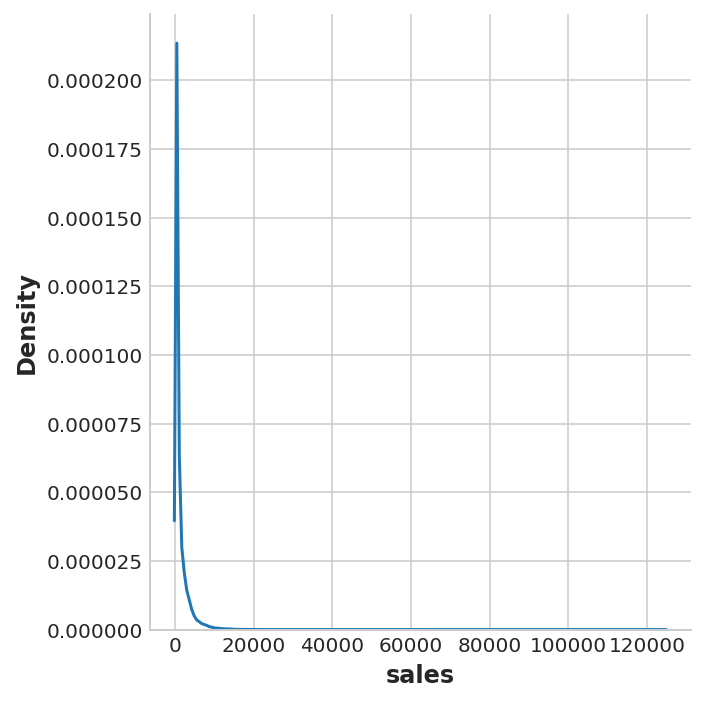

In [6]:
sns.displot(train, x='sales', kind="kde");

we can see that target values are completly skewed, so we transform it to make it more normal

In [7]:
train['sales'] = np.log1p(train['sales'])

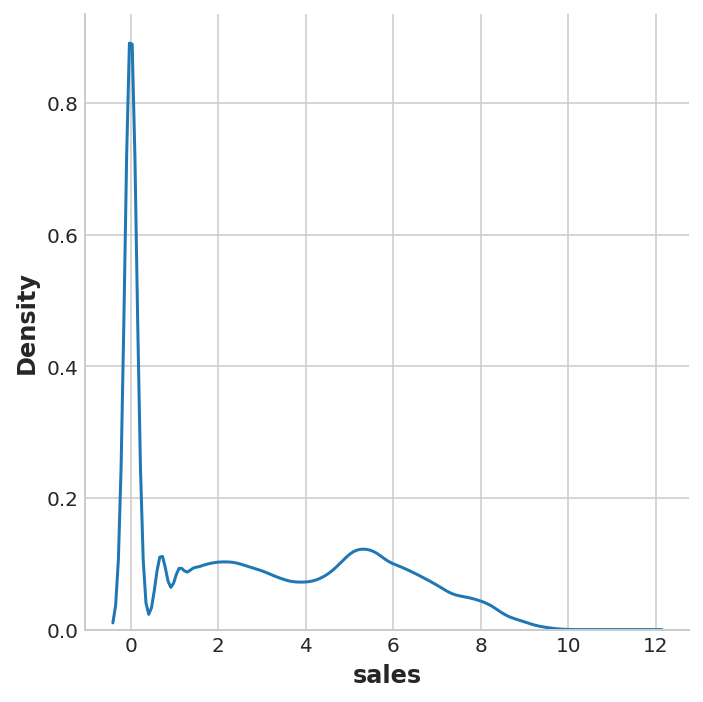

In [8]:
sns.displot(train, x='sales', kind="kde");

In [9]:
store_sales = pd.read_csv(
    "/kaggle/input/store-sales-time-series-forecasting/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales.head()

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.0
1,2013-01-01,1,BABY CARE,0.0
2,2013-01-01,1,BEAUTY,0.0
3,2013-01-01,1,BEVERAGES,0.0
4,2013-01-01,1,BOOKS,0.0


## EDA

In [10]:
for name, df in datasets.items():
  print(name)
  df.info(null_counts=True)
  print("\n\n")

train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype    
---  ------       --------------    -----    
 0   id           3000888 non-null  int64    
 1   date         3000888 non-null  period[D]
 2   store_nbr    3000888 non-null  category 
 3   family       3000888 non-null  category 
 4   sales        3000888 non-null  float32  
 5   onpromotion  3000888 non-null  int64    
dtypes: category(2), float32(1), int64(2), period[D](1)
memory usage: 85.9 MB



test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   id           28512 non-null  int64    
 1   date         28512 non-null  period[D]
 2   store_nbr    28512 non-null  category 
 3   family       28512 non-null  category 
 4   onpromotion  28512 non-null  int64    
dtypes: cate

## Engineer oil features

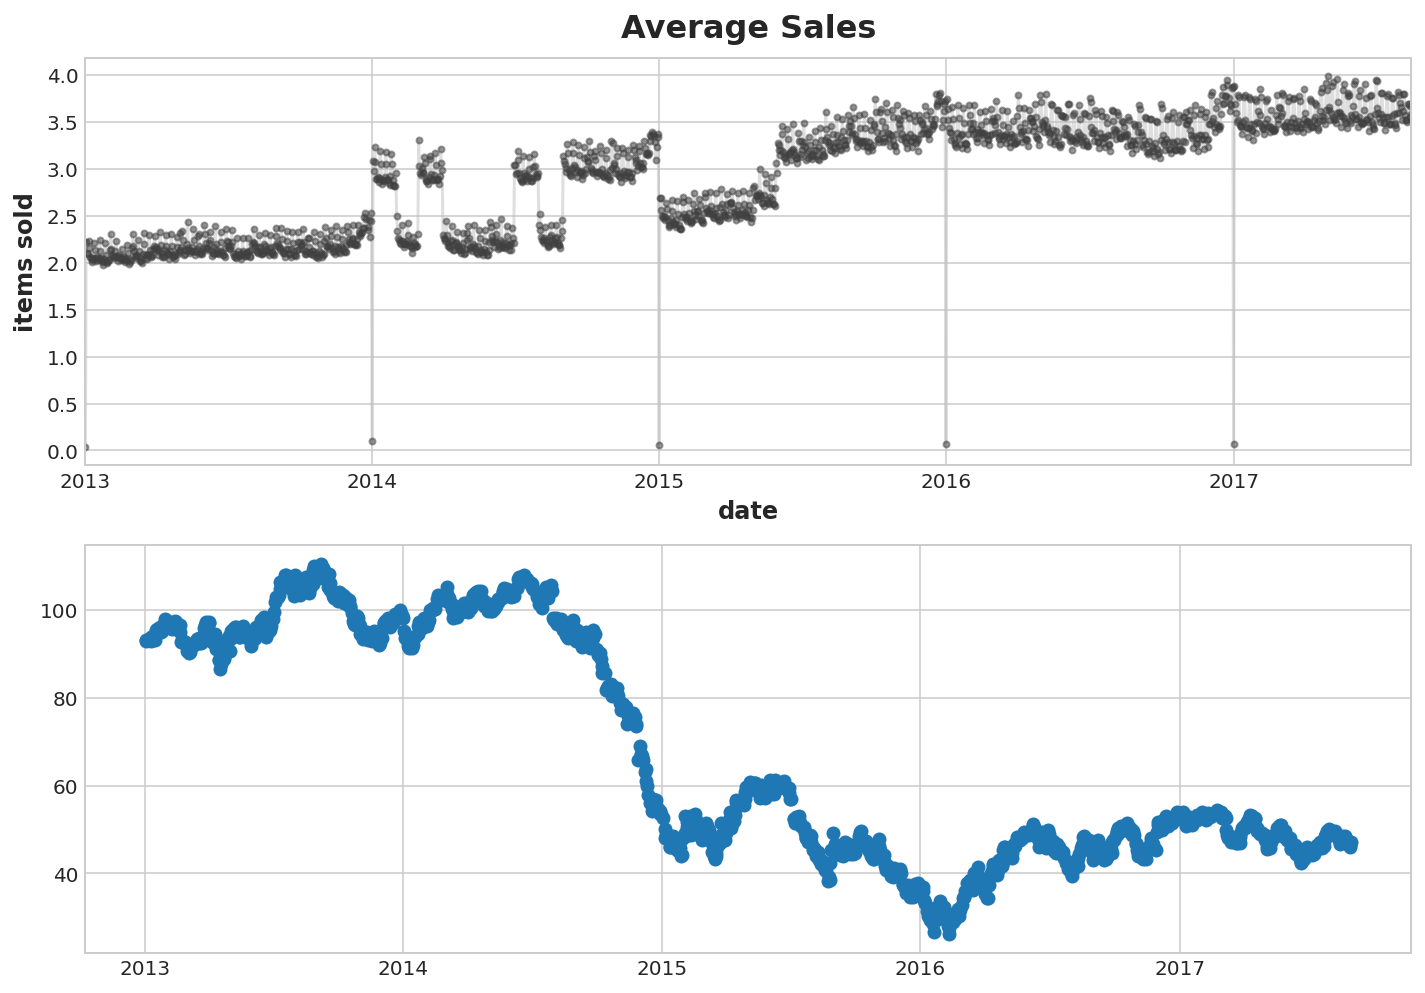

In [11]:
average_sales_all = (
    train
    .groupby('date')['sales'].mean()
    .squeeze()
)

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(10, 7))
ax1 = average_sales_all.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold", ax=ax1)
ax2 = plt.plot_date(oil.index, oil["dcoilwtico"])

It is clear that as the oil prices decrease, sales increase. Therefore it should be useful to include the oil dataset.

In [12]:
oil['avg_oil'] = oil['dcoilwtico'].rolling(window=7).mean()

In [13]:
oil.avg_oil.fillna(method = 'bfill', inplace = True)
oil.dropna(inplace = True)

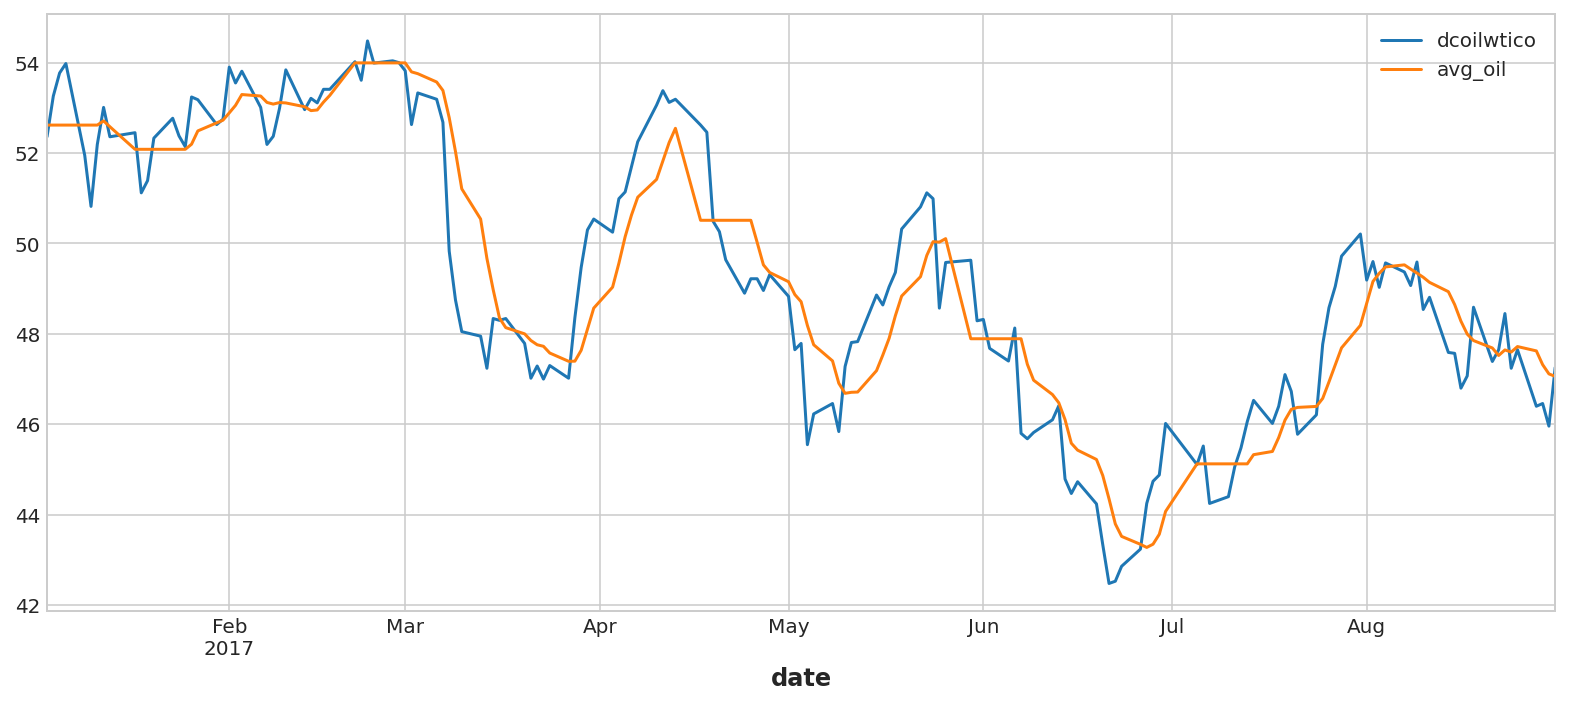

In [14]:
oil['2017-01-01':].plot();

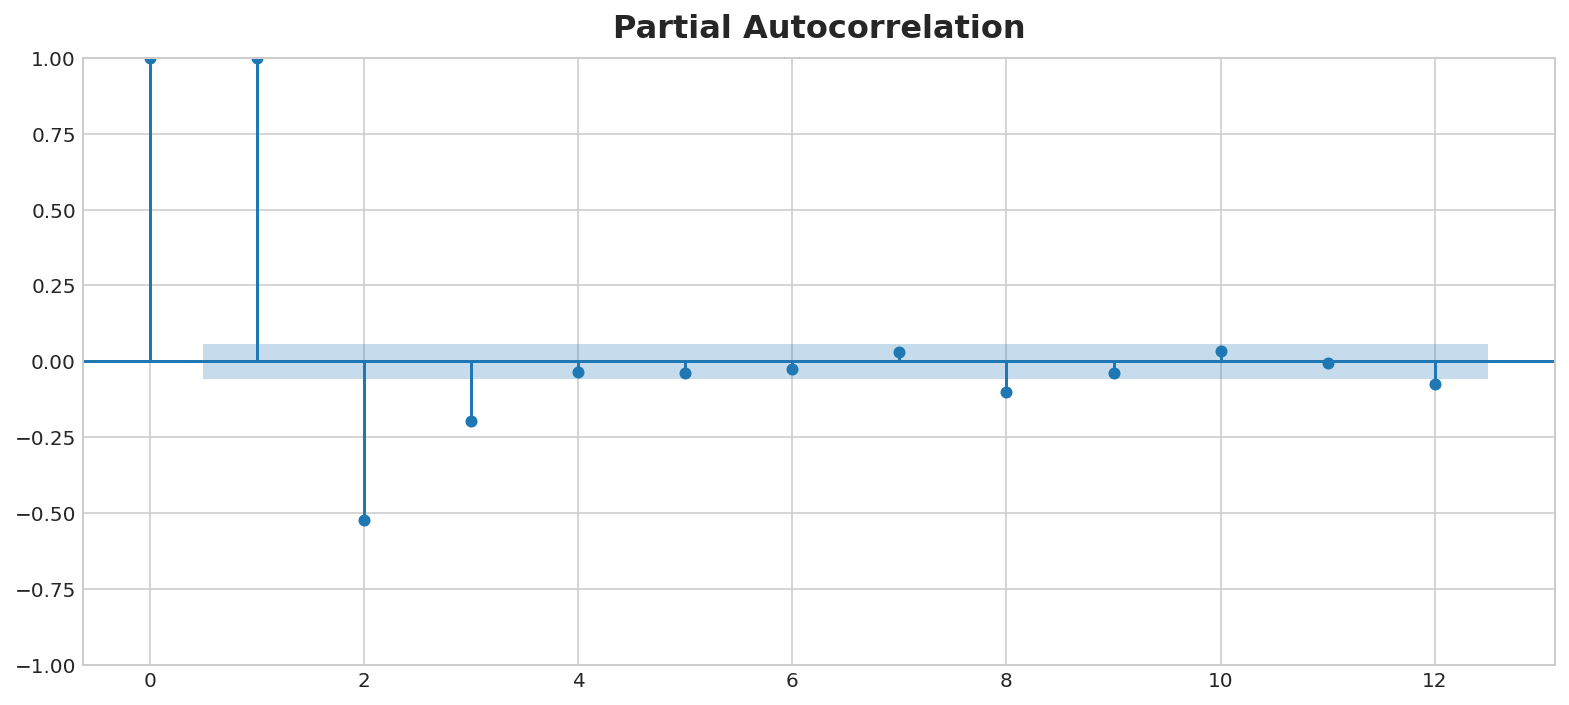

In [15]:
# Now check the inner-dependence of oil prices
# by looking at the partial autocorrelation graphs

plot_pacf(oil.avg_oil, lags = 12);

In [16]:
oil.drop('dcoilwtico', axis=1, inplace=True)
lags = 3
oil_lags = pd.concat(
        {
            f'oil_lag_{i}': oil.avg_oil.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)
oil = pd.concat([oil, oil_lags], axis=1).fillna(method='bfill')
oil

,avg_oil,oil_lag_1,oil_lag_2,oil_lag_3
date,,,,
2013-01-02,93.218571,93.218571,93.218571,93.218571
2013-01-03,93.218571,93.218571,93.218571,93.218571
2013-01-04,93.218571,93.218571,93.218571,93.218571
2013-01-07,93.218571,93.218571,93.218571,93.218571
2013-01-08,93.218571,93.218571,93.218571,93.218571
...,...,...,...,...
2017-08-25,47.720000,47.598571,47.645714,47.522857
2017-08-28,47.624286,47.720000,47.598571,47.645714
2017-08-29,47.320000,47.624286,47.720000,47.598571


In [17]:
calendar = pd.concat([train.date, test.date]).to_frame()
calendar = calendar.groupby('date').first()
calendar

""
date
2013-01-01
2013-01-02
2013-01-03
2013-01-04
2013-01-05
...
2017-08-27
2017-08-28
2017-08-29


In [18]:
oil_alldays = calendar.merge(oil, on='date', how='left')
oil_alldays.fillna(method='bfill', inplace=True)
oil_alldays.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1700 entries, 2013-01-01 to 2017-08-31
Freq: D
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   avg_oil    1700 non-null   float64
 1   oil_lag_1  1700 non-null   float64
 2   oil_lag_2  1700 non-null   float64
 3   oil_lag_3  1700 non-null   float64
dtypes: float64(4)
memory usage: 66.4 KB


## Engineer transactions

In [19]:
transactions = transactions.unstack('store_nbr')
transactions

transactions                                                  \
store_nbr             1      10      11      12      13      14      15   
date                                                                      
2013-01-01          NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2013-01-02       2111.0  1293.0  3547.0  1362.0  1102.0  2002.0  1622.0   
2013-01-03       1833.0  1157.0  2675.0  1248.0   916.0  1823.0  1512.0   
2013-01-04       1863.0   970.0  2515.0  1064.0   879.0  1641.0  1318.0   
2013-01-05       1509.0  1269.0  3052.0  1293.0  1336.0  2052.0  1543.0   
...                 ...     ...     ...     ...     ...     ...     ...   
2017-08-11        570.0   728.0  2254.0  1057.0   841.0  1072.0  1074.0   
2017-08-12       1004.0   953.0  2230.0  1103.0  1023.0  1359.0  1161.0   
2017-08-13        416.0   810.0  2101.0  1066.0   769.0   803.0   892.0   
2017-08-14       1733.0   875.0  2203.0  1061.0   835.0  1293.0  1431.0   
2017-08-15       1693.0  1010.0  2360.0  1096.0   842.0  1241.0  1320.0   

                                    ...                                  \
store_nbr       16      17      18  ...       5      50      51      52   
date                                ...                                   
2013-01-01     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
2013-01-02  1167.0  1580.0  1635.0  ...  1903.0  3077.0  1985.0     NaN   
2013-01-03  1101.0  1339.0  1484.0  ...  1740.0  2307.0  1644.0     NaN   
2013-01-04   977.0  1139.0  1238.0  ...  1642.0  2698.0  1786.0     NaN   
2013-01-05  1109.0  1433.0  1323.0  ...  1643.0  3459.0  2068.0     NaN   
...            ...     ...     ...  ...     ...     ...     ...     ...   
2017-08-11   736.0  1524.0   930.0  ...  1183.0  2971.0  1922.0  2957.0   
2017-08-12   717.0  1547.0   990.0  ...  1061.0  2987.0  1590.0  2804.0   
2017-08-13   727.0  1563.0  1075.0  ...  1098.0  2826.0  1816.0  2433.0   
2017-08-14   667.0  1323.0  1201.0  ...  1225.0  2555.0  1446.0  2074.0   
2017-08-15   742.0  1504.0  1343.0  ...  1310.0  2804.0  1573.0  2255.0   

                                                            
store_nbr       53      54       6       7       8       9  
date                                                        
2013-01-01     NaN     NaN     NaN     NaN     NaN     NaN  
2013-01-02     NaN   998.0  2143.0  1874.0  3250.0  2940.0  
2013-01-03     NaN   920.0  1795.0  1568.0  2904.0  2396.0  
2013-01-04     NaN   794.0  1679.0  1513.0  2962.0  1975.0  
2013-01-05     NaN   949.0  2154.0  1599.0  3060.0  2604.0  
...            ...     ...     ...     ...     ...     ...  
2017-08-11  1272.0   768.0  1747.0  1541.0  2212.0  1848.0  
2017-08-12  1212.0   903.0  1706.0  1612.0  2463.0  1920.0  
2017-08-13  1164.0  1054.0  1781.0  1410.0  2355.0  1745.0  
2017-08-14   895.0   818.0  1593.0  1793.0  2723.0  1971.0  
2017-08-15   932.0   802.0  1589.0  1780.0  2621.0  2155.0  

[1682 rows x 54 columns]

In [20]:
transactions, _ = transactions.align(calendar, join='outer', axis=0)
transactions.fillna(method='bfill', inplace=True)
transactions

transactions                                                  \
store_nbr             1      10      11      12      13      14      15   
date                                                                      
2013-01-01       2111.0  1293.0  3547.0  1362.0  1102.0  2002.0  1622.0   
2013-01-02       2111.0  1293.0  3547.0  1362.0  1102.0  2002.0  1622.0   
2013-01-03       1833.0  1157.0  2675.0  1248.0   916.0  1823.0  1512.0   
2013-01-04       1863.0   970.0  2515.0  1064.0   879.0  1641.0  1318.0   
2013-01-05       1509.0  1269.0  3052.0  1293.0  1336.0  2052.0  1543.0   
...                 ...     ...     ...     ...     ...     ...     ...   
2017-08-27          NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2017-08-28          NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2017-08-29          NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2017-08-30          NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2017-08-31          NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                                    ...                                  \
store_nbr       16      17      18  ...       5      50      51      52   
date                                ...                                   
2013-01-01  1167.0  1580.0  1635.0  ...  1903.0  3077.0  1985.0  4068.0   
2013-01-02  1167.0  1580.0  1635.0  ...  1903.0  3077.0  1985.0  4068.0   
2013-01-03  1101.0  1339.0  1484.0  ...  1740.0  2307.0  1644.0  4068.0   
2013-01-04   977.0  1139.0  1238.0  ...  1642.0  2698.0  1786.0  4068.0   
2013-01-05  1109.0  1433.0  1323.0  ...  1643.0  3459.0  2068.0  4068.0   
...            ...     ...     ...  ...     ...     ...     ...     ...   
2017-08-27     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
2017-08-28     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
2017-08-29     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
2017-08-30     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
2017-08-31     NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   

                                                           
store_nbr       53     54       6       7       8       9  
date                                                       
2013-01-01  2545.0  998.0  2143.0  1874.0  3250.0  2940.0  
2013-01-02  2545.0  998.0  2143.0  1874.0  3250.0  2940.0  
2013-01-03  2545.0  920.0  1795.0  1568.0  2904.0  2396.0  
2013-01-04  2545.0  794.0  1679.0  1513.0  2962.0  1975.0  
2013-01-05  2545.0  949.0  2154.0  1599.0  3060.0  2604.0  
...            ...    ...     ...     ...     ...     ...  
2017-08-27     NaN    NaN     NaN     NaN     NaN     NaN  
2017-08-28     NaN    NaN     NaN     NaN     NaN     NaN  
2017-08-29     NaN    NaN     NaN     NaN     NaN     NaN  
2017-08-30     NaN    NaN     NaN     NaN     NaN     NaN  
2017-08-31     NaN    NaN     NaN     NaN     NaN     NaN  

[1700 rows x 54 columns]

if we want to use transaction as leading feature we should use a lag of degree at least 16 of this feature.

In [21]:
transactions = make_lags(transactions, lags=[16])['transactions_lag_16'].stack('store_nbr').to_frame('transactions')
transactions

transactions
date       store_nbr              
2013-01-17 1                2111.0
           10               1293.0
           11               3547.0
           12               1362.0
           13               1102.0
...                            ...
2017-08-31 54                802.0
           6                1589.0
           7                1780.0
           8                2621.0
           9                2155.0

[90936 rows x 1 columns]

## Overall Seasonality

In [22]:
# we'll use average_sales as a representative of the whole data and visualize it.
average_sales = (
    store_sales
    .groupby('date')['sales'].mean()
    .squeeze()
    .loc['2017']
)
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

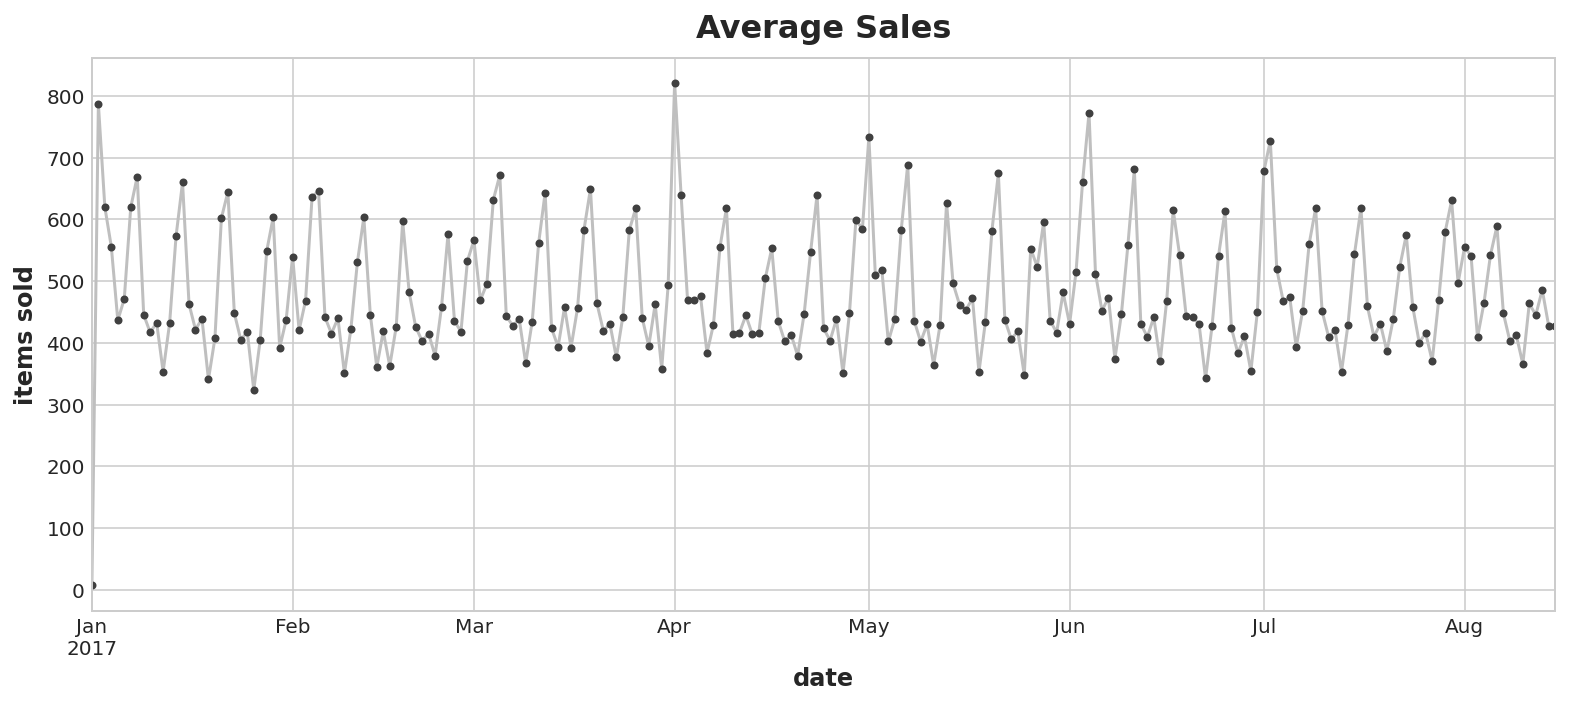

In [23]:
average_sales.plot(**plot_params, title="Average Sales", ylabel="items sold");

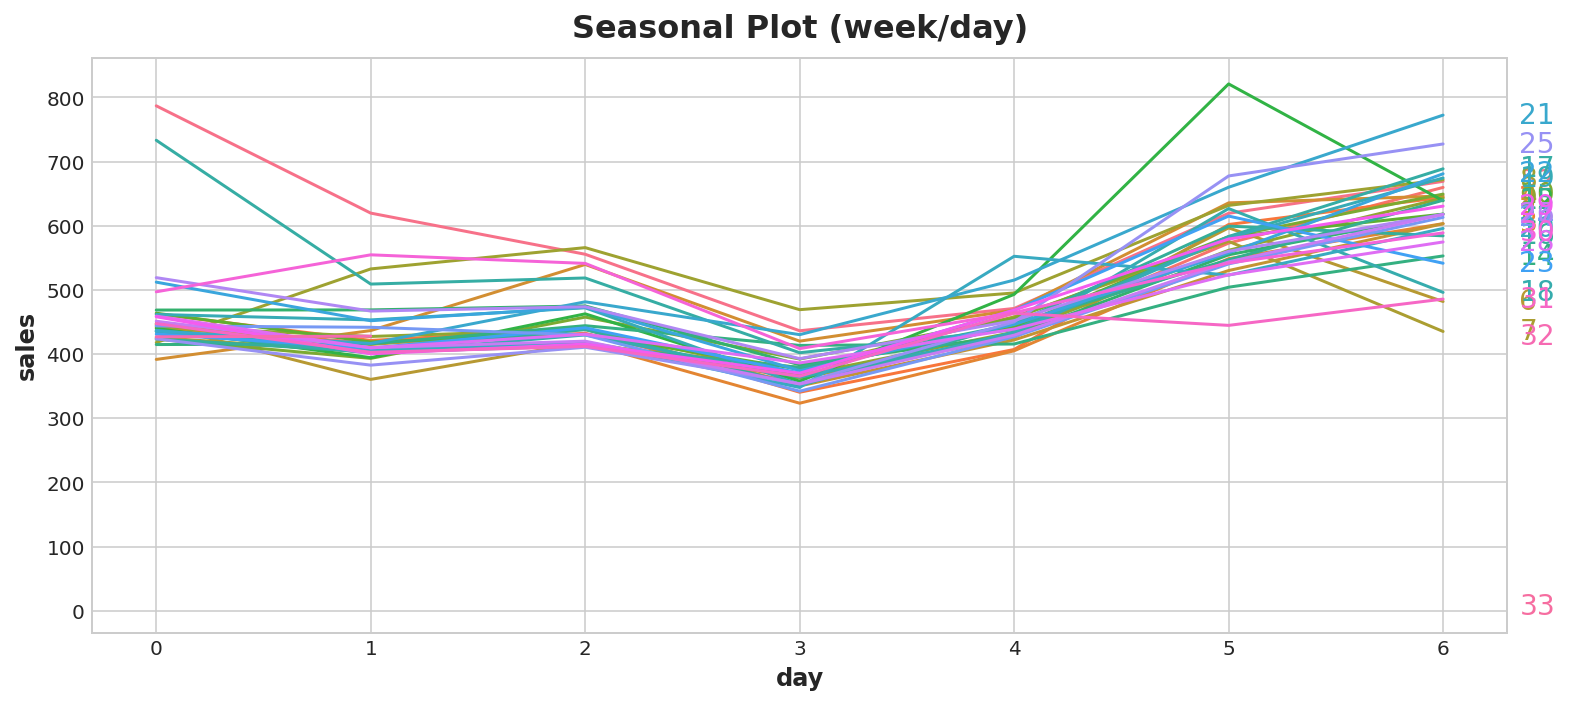

In [24]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

It shows a pattern of week seasonality; lets look at periodogram plot for more information:

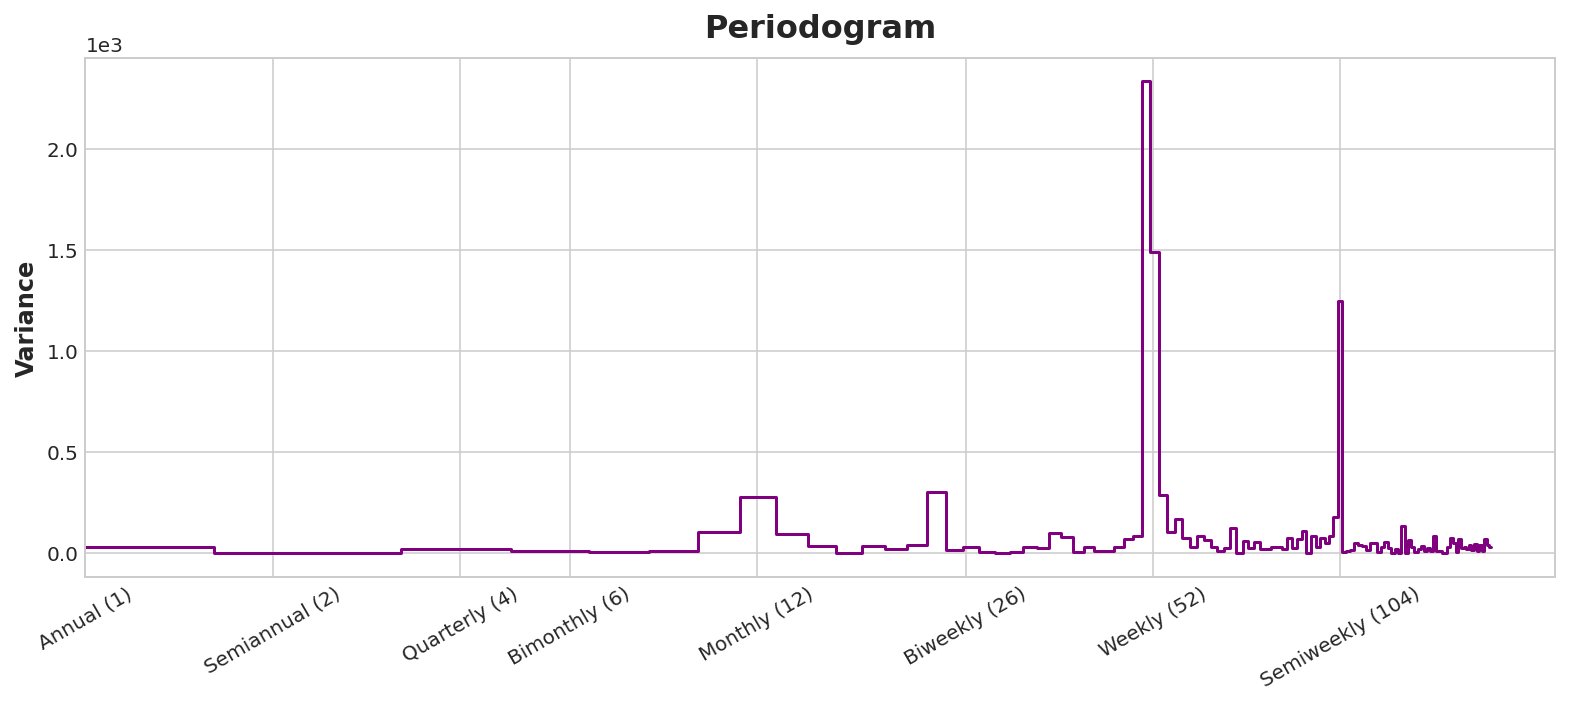

In [25]:
plot_periodogram(average_sales);

as we are seeing, we have strong weekly seasnolity that we can capture them using seasonal indicators, also we have some biweekly and monthly seasonalities that we'll catch them using 4 pair of sin/cos features:

In [26]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

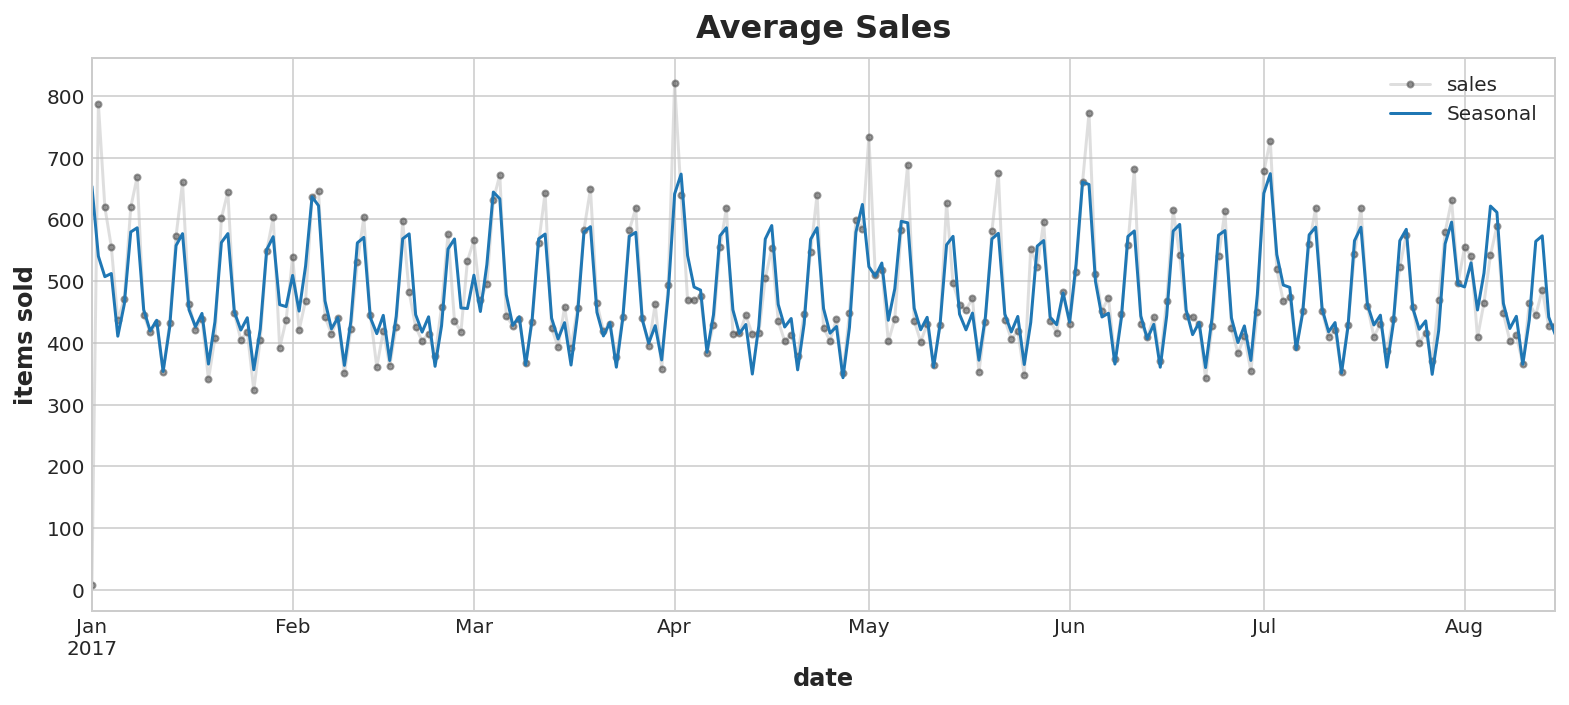

In [27]:
model = LinearRegression().fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Let's deseason our time series to see if we captured all seasolaties:

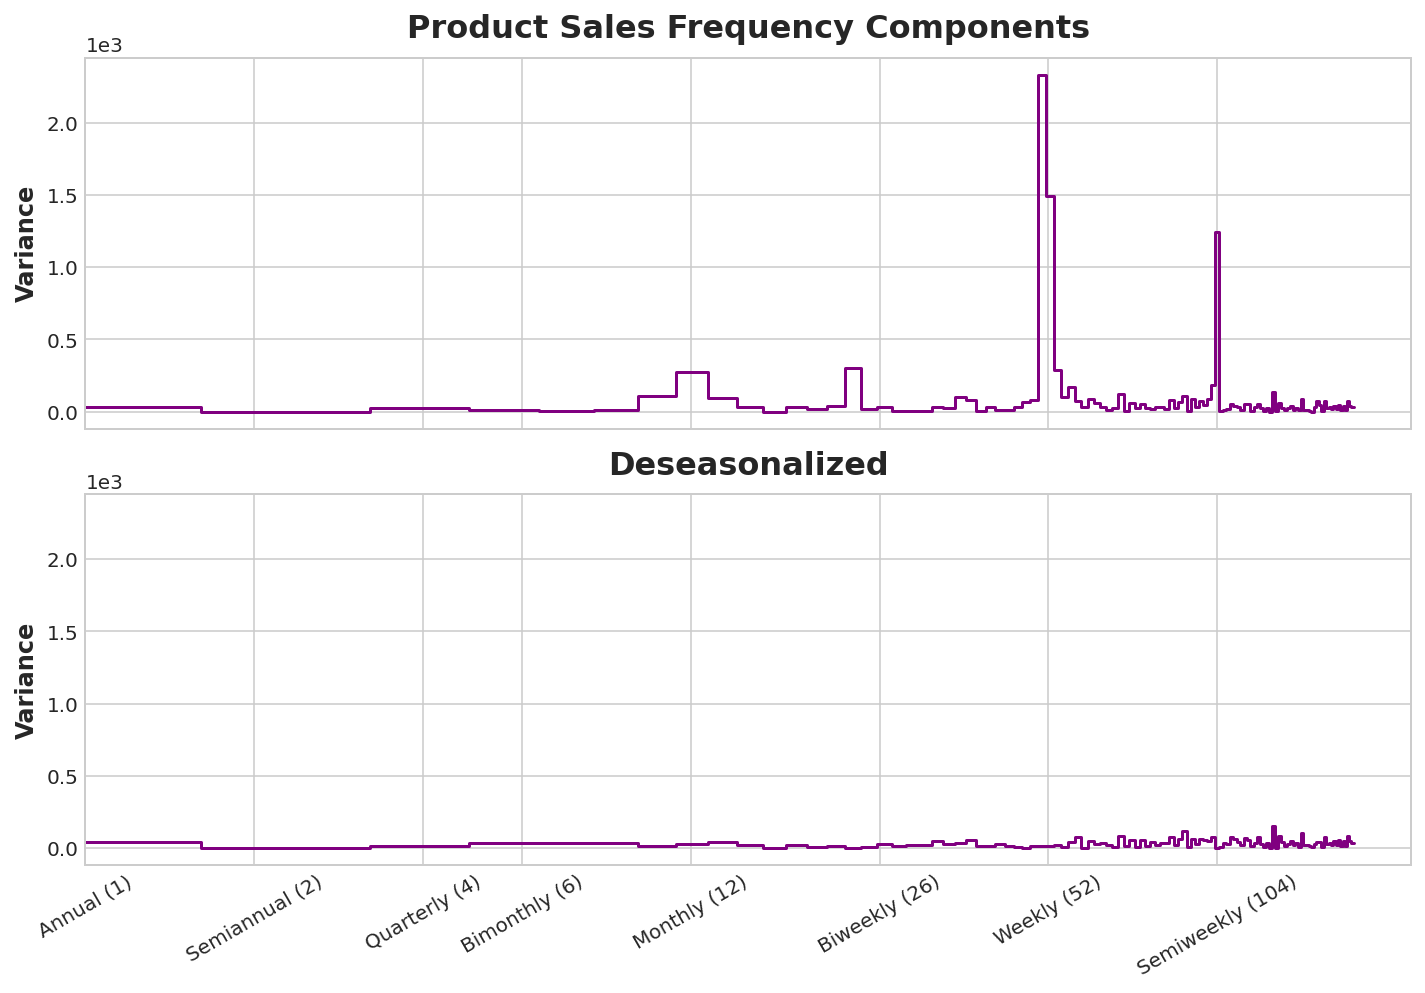

In [28]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

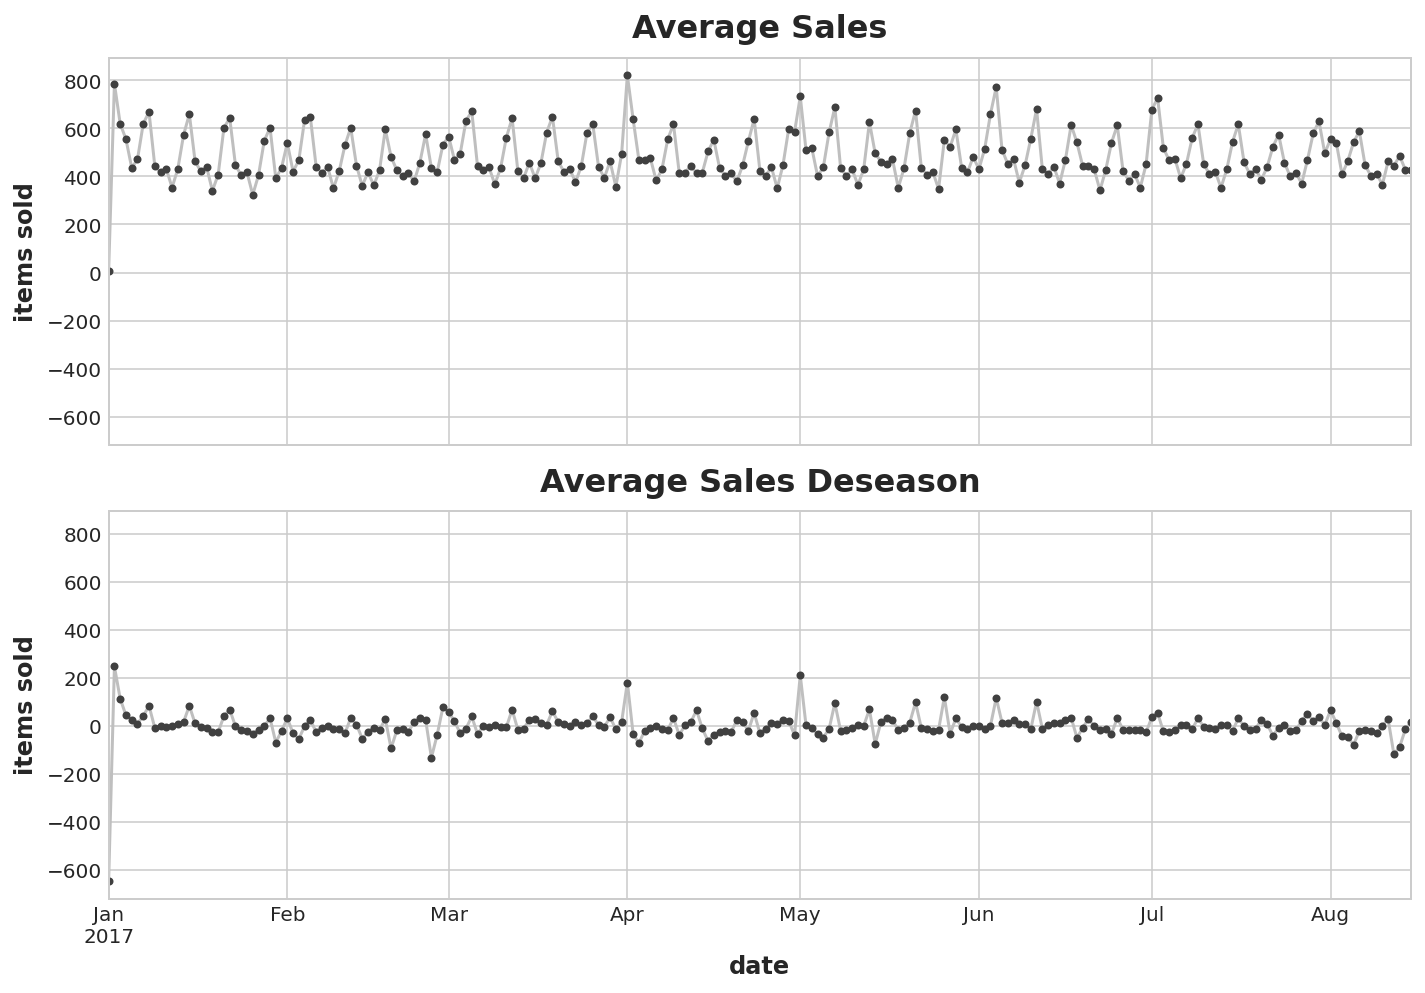

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
average_sales.plot(**plot_params, title="Average Sales", ylabel="items sold", ax=ax1)
y_deseason.plot(**plot_params, title="Average Sales Deseason", ylabel="items sold", ax=ax2);

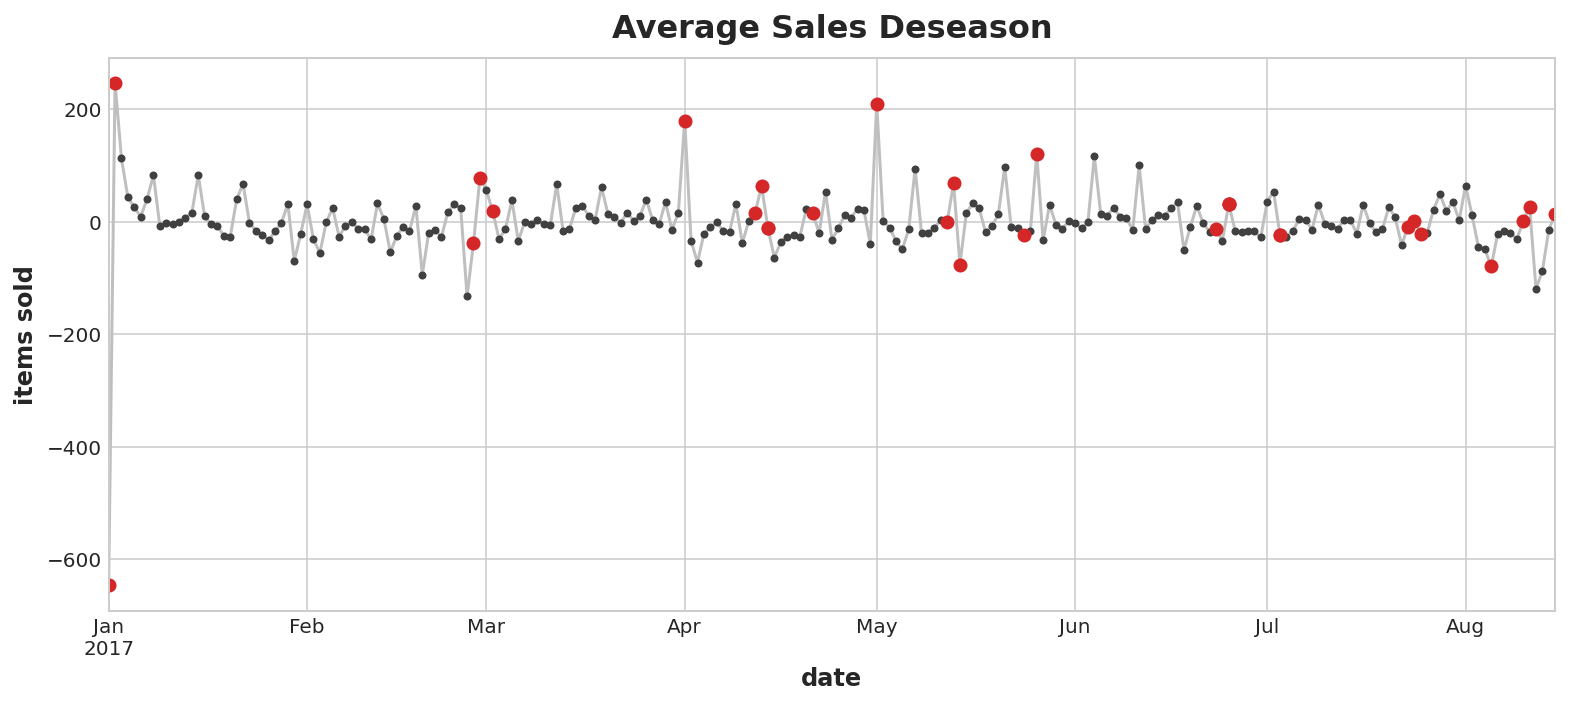

In [30]:
holidays_events = holidays['description']['2017-01-01':'2017-08-16']

y_deseason.plot(**plot_params, title="Average Sales Deseason", ylabel="items sold")
plt.plot_date(x=holidays_events.index, y=y_deseason[holidays_events.index], color='C3');

it appears that holidays events are important data for forcasting

## Engineer holidays events

In [31]:
select_events = holidays.groupby(holidays.index).first() # Removing duplicated holiday at the same date

select_events['weekday'] = 1
select_events.loc[select_events.index.day_of_week > 4, 'weekday'] = 0
print("Before engineering, the number of weekdays is:", select_events.weekday.sum())

# Weekdays that are Bridge/Transfer are false weekdays
select_events.loc[select_events.type.isin(['Bridge','Transfer']),'weekday'] = 0
# Weekdays that are Work Day are true weekdays
select_events.loc[select_events.type == 'Work Day','weekday'] = 1

# Weekdays that are Holiday and Not Transferred are false weekdays
select_events.loc[(select_events.type == 'Holiday') & (select_events.transferred == False),'weekday'] = 0
# Weekdays that are Holiday and Transferred are true weekdays
select_events.loc[(select_events.type == 'Holiday') & (select_events.transferred == True ),'weekday'] = 1
print("After engineering, the number of weekdays is:", select_events.weekday.sum())

select_events[:5]

Before engineering, the number of weekdays is: 221
After engineering, the number of weekdays is: 77


,type,locale,locale_name,description,transferred,weekday
date,,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,0
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,0
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,0
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,0
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,0


In [32]:
select_events.drop(['locale', 'locale_name', 'description', 'transferred'],axis=1,inplace=True)
select_events = pd.get_dummies(select_events, columns = ['type'])
select_events.head()

,weekday,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,
2012-03-02,0,0,0,0,1,0,0
2012-04-01,0,0,0,0,1,0,0
2012-04-12,0,0,0,0,1,0,0
2012-04-14,0,0,0,0,1,0,0
2012-04-21,0,0,0,0,1,0,0


In [33]:
events_alldays = calendar.merge(select_events, on='date', how='left')
events_alldays[['type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday',
       'type_Transfer', 'type_Work Day']] = events_alldays[['type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday',
                  'type_Transfer', 'type_Work Day']].fillna(0)
events_alldays.loc[events_alldays['weekday'].isna(), 'weekday'] = events_alldays.loc[events_alldays['weekday'].isna(), :].index.day_of_week <= 4
events_alldays['weekday'] = events_alldays['weekday'].astype('bool')
events_alldays.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1700 entries, 2013-01-01 to 2017-08-31
Freq: D
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   weekday          1700 non-null   bool   
 1   type_Additional  1700 non-null   float64
 2   type_Bridge      1700 non-null   float64
 3   type_Event       1700 non-null   float64
 4   type_Holiday     1700 non-null   float64
 5   type_Transfer    1700 non-null   float64
 6   type_Work Day    1700 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 94.6 KB


## Preparing Data

In [34]:
sales = train.set_index(["store_nbr", "family", "date"]).sort_index()[["sales"]].unstack(['store_nbr', 'family'])
_, sales = calendar.align(sales, join="outer", axis=0)
print(sales.shape)
sales

(1700, 1782)


sales                                                   \
store_nbr           1                                                    
family     AUTOMOTIVE BABY CARE    BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                     
2013-01-01   0.000000       0.0  0.000000  0.000000   0.0     0.000000   
2013-01-02   1.098612       0.0  1.098612  6.995766   0.0     6.156241   
2013-01-03   1.386294       0.0  0.000000  6.824374   0.0     5.741897   
2013-01-04   1.386294       0.0  1.386294  6.860664   0.0     5.295142   
2013-01-05   1.791759       0.0  1.386294  7.057037   0.0     5.710616   
...               ...       ...       ...       ...   ...          ...   
2017-08-27        NaN       NaN       NaN       NaN   NaN          NaN   
2017-08-28        NaN       NaN       NaN       NaN   NaN          NaN   
2017-08-29        NaN       NaN       NaN       NaN   NaN          NaN   
2017-08-30        NaN       NaN       NaN       NaN   NaN          NaN   
2017-08-31        NaN       NaN       NaN       NaN   NaN          NaN   

                                                      ...                      \
store_nbr                                             ...         9             
family     CELEBRATION  CLEANING     DAIRY      DELI  ... MAGAZINES     MEATS   
date                                                  ...                       
2013-01-01         0.0  0.000000  0.000000  0.000000  ...       0.0  0.000000   
2013-01-02         0.0  6.966967  6.363028  5.106364  ...       0.0  5.928341   
2013-01-03         0.0  6.729824  6.118097  5.027702  ...       0.0  5.996111   
2013-01-04         0.0  6.719013  6.133398  4.885911  ...       0.0  5.742612   
2013-01-05         0.0  6.699501  6.142037  4.784262  ...       0.0  6.106321   
...                ...       ...       ...       ...  ...       ...       ...   
2017-08-27         NaN       NaN       NaN       NaN  ...       NaN       NaN   
2017-08-28         NaN       NaN       NaN       NaN  ...       NaN       NaN   
2017-08-29         NaN       NaN       NaN       NaN  ...       NaN       NaN   
2017-08-30         NaN       NaN       NaN       NaN  ...       NaN       NaN   
2017-08-31         NaN       NaN       NaN       NaN  ...       NaN       NaN   

                                                                         \
store_nbr                                                                 
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   POULTRY   
date                                                                      
2013-01-01      0.000000          0.0                     0.0  0.000000   
2013-01-02      6.180017          0.0                     0.0  6.480492   
2013-01-03      5.921578          0.0                     0.0  6.235383   
2013-01-04      5.783825          0.0                     0.0  5.810158   
2013-01-05      6.135565          0.0                     0.0  6.238166   
...                  ...          ...                     ...       ...   
2017-08-27           NaN          NaN                     NaN       NaN   
2017-08-28           NaN          NaN                     NaN       NaN   
2017-08-29           NaN          NaN                     NaN       NaN   
2017-08-30           NaN          NaN                     NaN       NaN   
2017-08-31           NaN          NaN                     NaN       NaN   

                                                                        
store_nbr                                                               
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                                                    
2013-01-01       0.000000     0.0                        0.0  0.000000  
2013-01-02       4.430817     0.0                        0.0  3.408305  
2013-01-03       4.204693     0.0                        0.0  3.258096  
2013-01-04       4.060443     0.0                   

In [35]:
laged_sales = make_lags(sales, lags=[*range(1, 21)]).fillna(method='bfill')
laged_sales = laged_sales.stack(['store_nbr', 'family'])
laged_sales

sales_lag_1  sales_lag_10  \
date       store_nbr family                                                  
2013-01-01 1         AUTOMOTIVE                          0.0           0.0   
                     BABY CARE                           0.0           0.0   
                     BEAUTY                              0.0           0.0   
                     BEVERAGES                           0.0           0.0   
                     BOOKS                               0.0           0.0   
...                                                      ...           ...   
2017-08-31 9         POULTRY                             NaN           NaN   
                     PREPARED FOODS                      NaN           NaN   
                     PRODUCE                             NaN           NaN   
                     SCHOOL AND OFFICE SUPPLIES          NaN           NaN   
                     SEAFOOD                             NaN           NaN   

                                                 sales_lag_11  sales_lag_12  \
date       store_nbr family                                                   
2013-01-01 1         AUTOMOTIVE                           0.0           0.0   
                     BABY CARE                            0.0           0.0   
                     BEAUTY                               0.0           0.0   
                     BEVERAGES                            0.0           0.0   
                     BOOKS                                0.0           0.0   
...                                                       ...           ...   
2017-08-31 9         POULTRY                              NaN           NaN   
                     PREPARED FOODS                       NaN           NaN   
                     PRODUCE                              NaN           NaN   
                     SCHOOL AND OFFICE SUPPLIES           NaN           NaN   
                     SEAFOOD                              NaN           NaN   

                                                 sales_lag_13  sales_lag_14  \
date       store_nbr family                                                   
2013-01-01 1         AUTOMOTIVE                           0.0           0.0   
                     BABY CARE                            0.0           0.0   
                     BEAUTY                               0.0           0.0   
                     BEVERAGES                            0.0           0.0   
                     BOOKS                                0.0           0.0   
...                                                       ...           ...   
2017-08-31 9         POULTRY                              NaN           NaN   
                     PREPARED FOODS                       NaN           NaN   
                     PRODUCE                              NaN           NaN   
                     SCHOOL AND OFFICE SUPPLIES           NaN           NaN   
                     SEAFOOD                              NaN           NaN   

                                                 sales_lag_15  sales_lag_16  \
date       store_nbr family                                                   
2013-01-01 1         AUTOMOTIVE                           0.0      0.000000   
                     BABY CARE                            0.0      0.000000   
                     BEAUTY                               0.0      0.000000   
                     BEVERAGES                            0.0      0.000000   
                     BOOKS                                0.0      0.000000   
...                                                       ...           ...   
2017-08-31 9         POULTRY                              NaN      6.084802   
                     PREPARED FOODS                       NaN      5.046987   
                     PRODUCE                              NaN      7.791824   
                     SCHOOL AND OFFICE SUPPLIES           NaN      4.804021   
                     SEAFOOD  

In [36]:
# Calendar features
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    return df

In [37]:
data = pd.concat([train, test])

data = data.merge(stores, left_on="store_nbr", right_on="store_nbr", how="left") \
        .rename(columns={"type": "store_type"}) \
        .merge(transactions, left_on=["date", "store_nbr"], right_on=["date", "store_nbr"], how="left") \
        .merge(events_alldays, left_on="date", right_on="date", how="left") \
        .drop_duplicates(subset="id") \
        .rename(columns={"type": "holiday_type"}) \
        .merge(oil_alldays, left_on="date", right_on="date", how="left") \
        .merge(laged_sales, on=["date", "store_nbr", "family"], how='left')
data = create_date_features(data)
data.set_index('id', inplace=True, drop=True)
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3029400 entries, 0 to 3029399
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype    
---  ------           --------------    -----    
 0   date             3029400 non-null  period[D]
 1   store_nbr        3029400 non-null  category 
 2   family           3029400 non-null  category 
 3   sales            3000888 non-null  float32  
 4   onpromotion      3029400 non-null  int64    
 5   city             3029400 non-null  category 
 6   state            3029400 non-null  category 
 7   store_type       3029400 non-null  category 
 8   cluster          3029400 non-null  int64    
 9   transactions     3000888 non-null  float64  
 10  weekday          3029400 non-null  bool     
 11  type_Additional  3029400 non-null  float64  
 12  type_Bridge      3029400 non-null  float64  
 13  type_Event       3029400 non-null  float64  
 14  type_Holiday     3029400 non-null  float64  
 15  type_Transfer    3029400 non-nul

In [38]:
def plot_scores(scores, title="Scores"):
    f, ax = plt.subplots(figsize=(15, 20))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks, fontsize=20)
    plt.title(title)

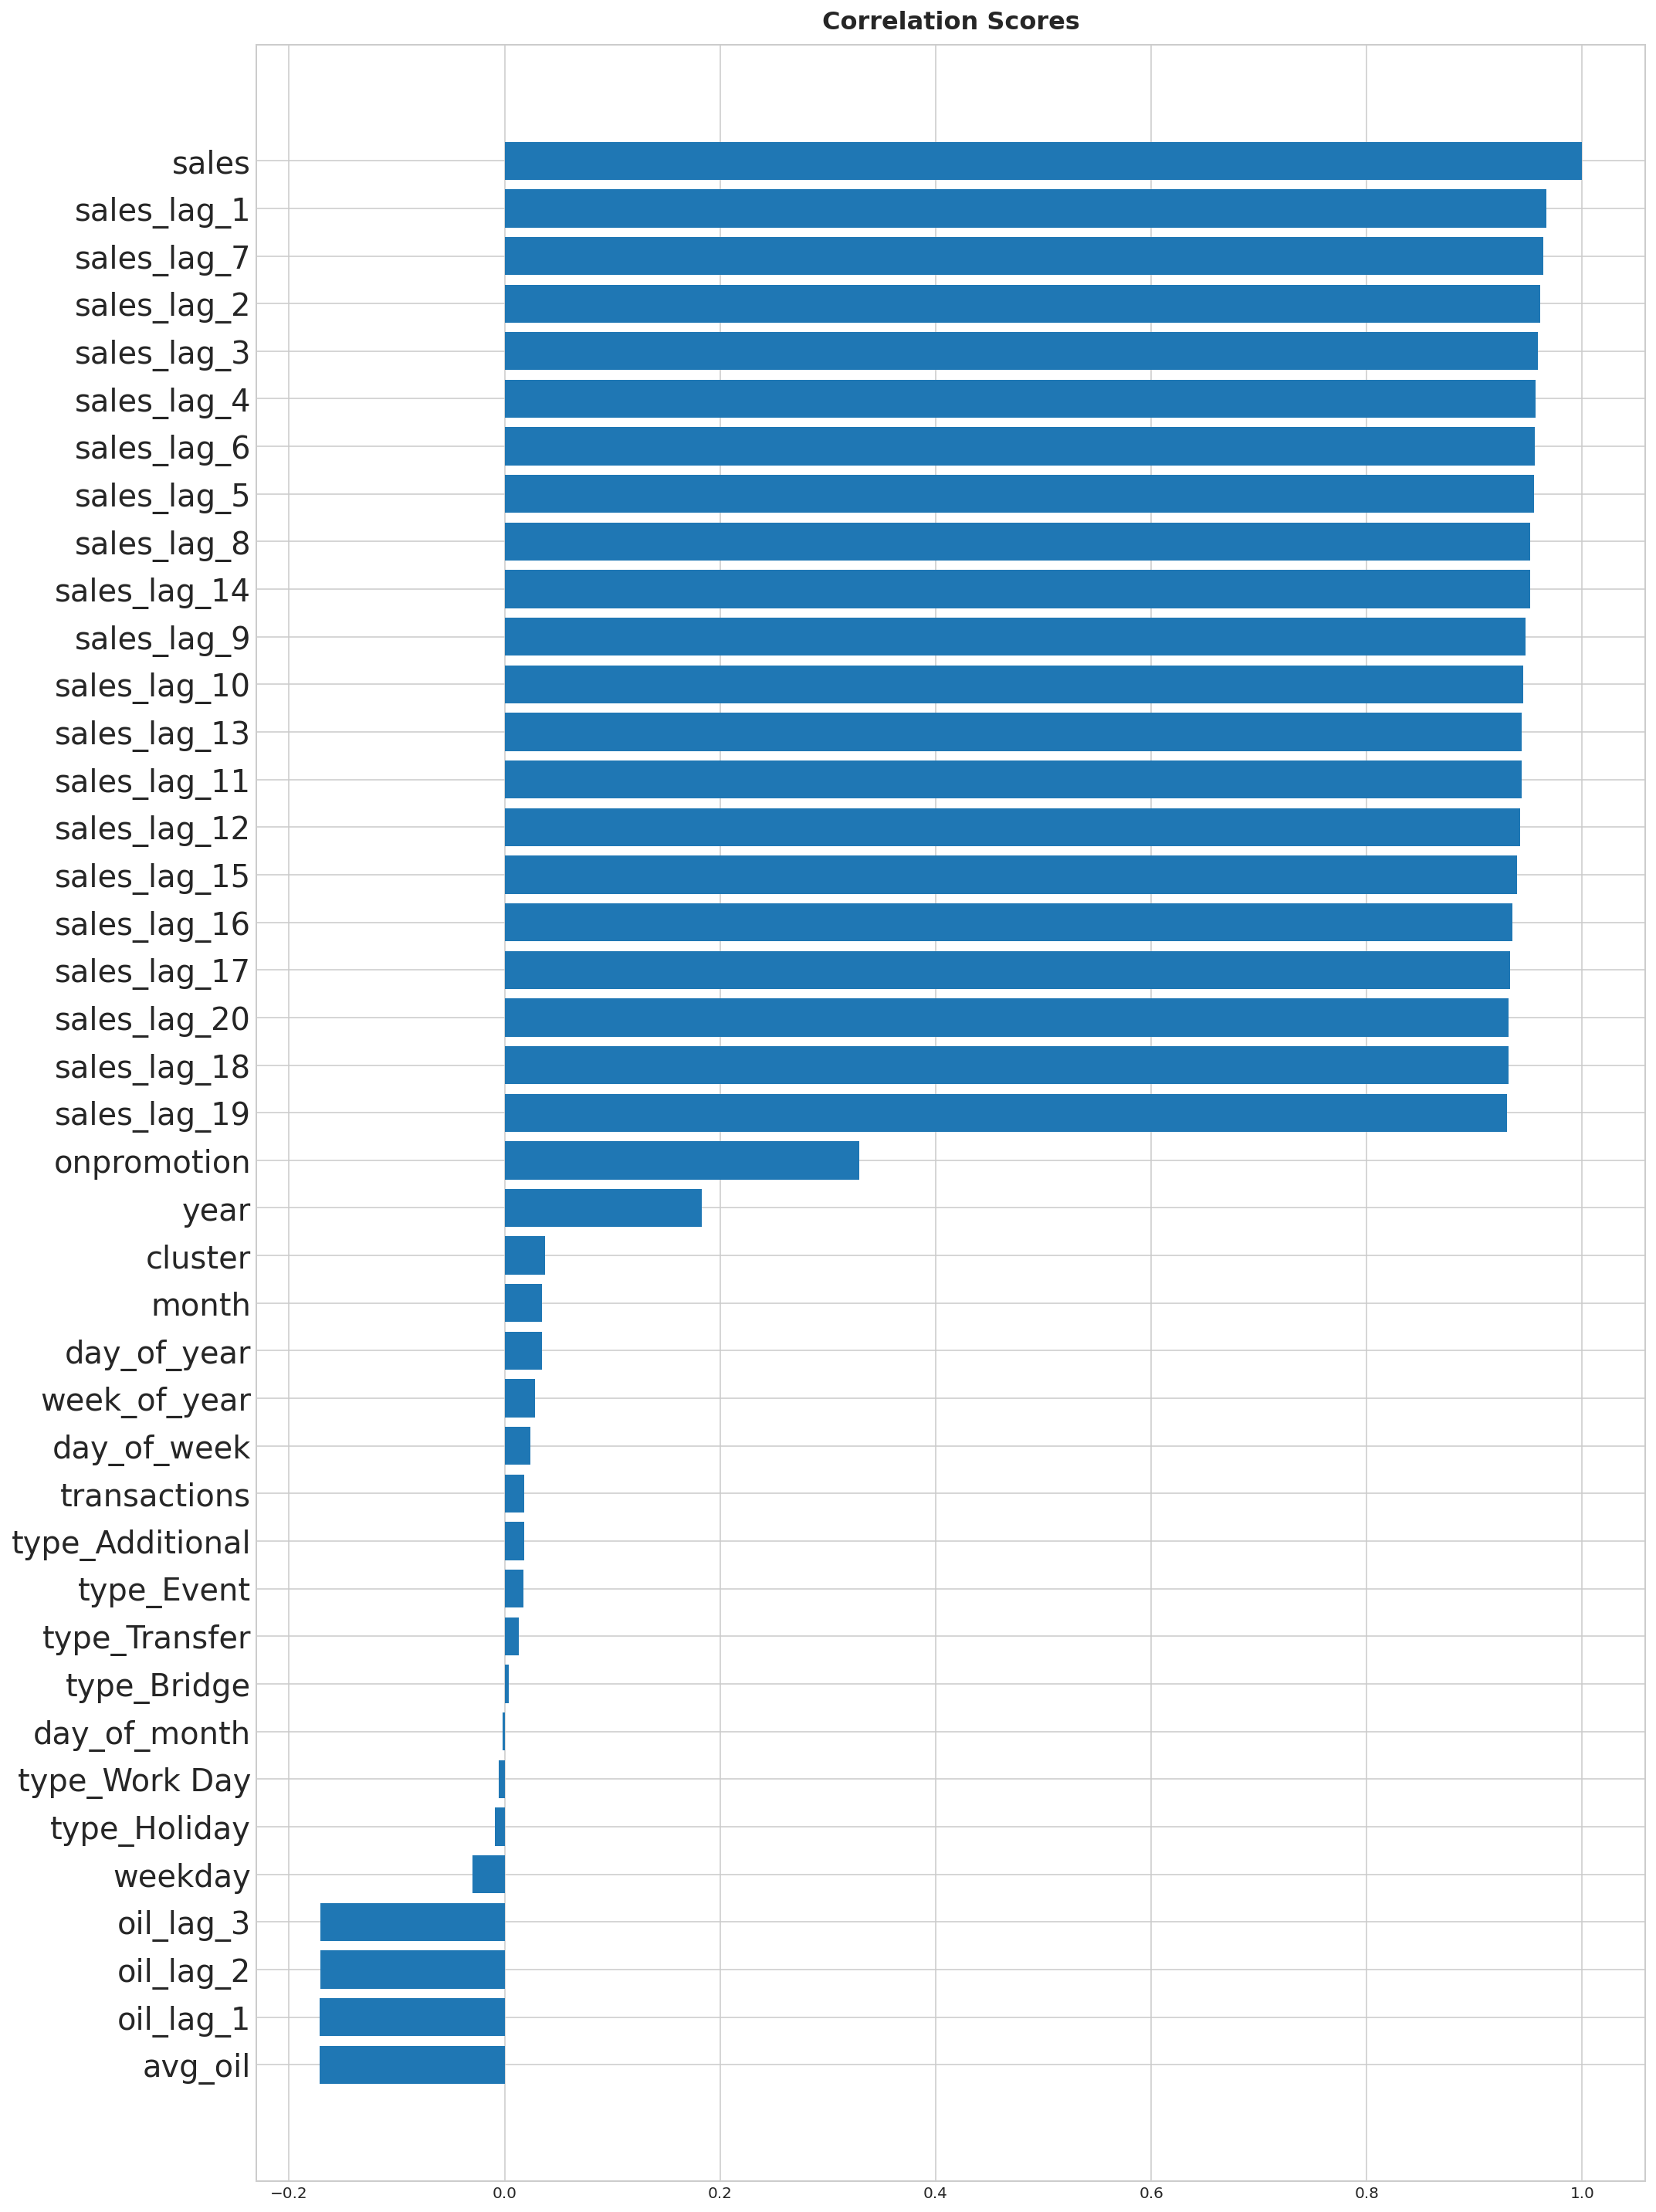

In [39]:
corr = data.corr()
corr_scores = corr['sales'].sort_values(ascending=False)
plot_scores(corr_scores, "Correlation Scores")

In [40]:
# for calculating mi, it's better to charactrize the descret features
data['type_Additional'] = data['type_Additional'].astype('int32')
data['type_Bridge'] = data['type_Bridge'].astype('int32')
data['type_Event'] = data['type_Event'].astype('int32')
data['type_Holiday'] = data['type_Holiday'].astype('int32')
data['type_Transfer'] = data['type_Transfer'].astype('int32')
data['type_Work Day'] = data['type_Work Day'].astype('int32')

In [41]:
from sklearn.feature_selection import mutual_info_regression
import time

def make_mi_scores(train, y):
    start_time = time.time()
    train = train.copy()
    train.drop('date', axis=1, inplace=True)
    for colname in train.select_dtypes(["object", "category"]):
        train[colname], feature_names = train[colname].factorize()
    
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in train.dtypes]
    mi_scores = mutual_info_regression(train, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    print("execution time: ", time.time() - start_time)
    return mi_scores

# since calculations for mi are more complicated, we use a subset of data for making scores
data_test = data.query("'2017-04-01' <= date <= '2017-08-15'")
print("shape of the data used for making scores: ", data_test.shape)
mi_scores = make_mi_scores(data_test, data_test['sales'])

shape of the data used for making scores:  (244134, 47)
execution time:  129.5103199481964


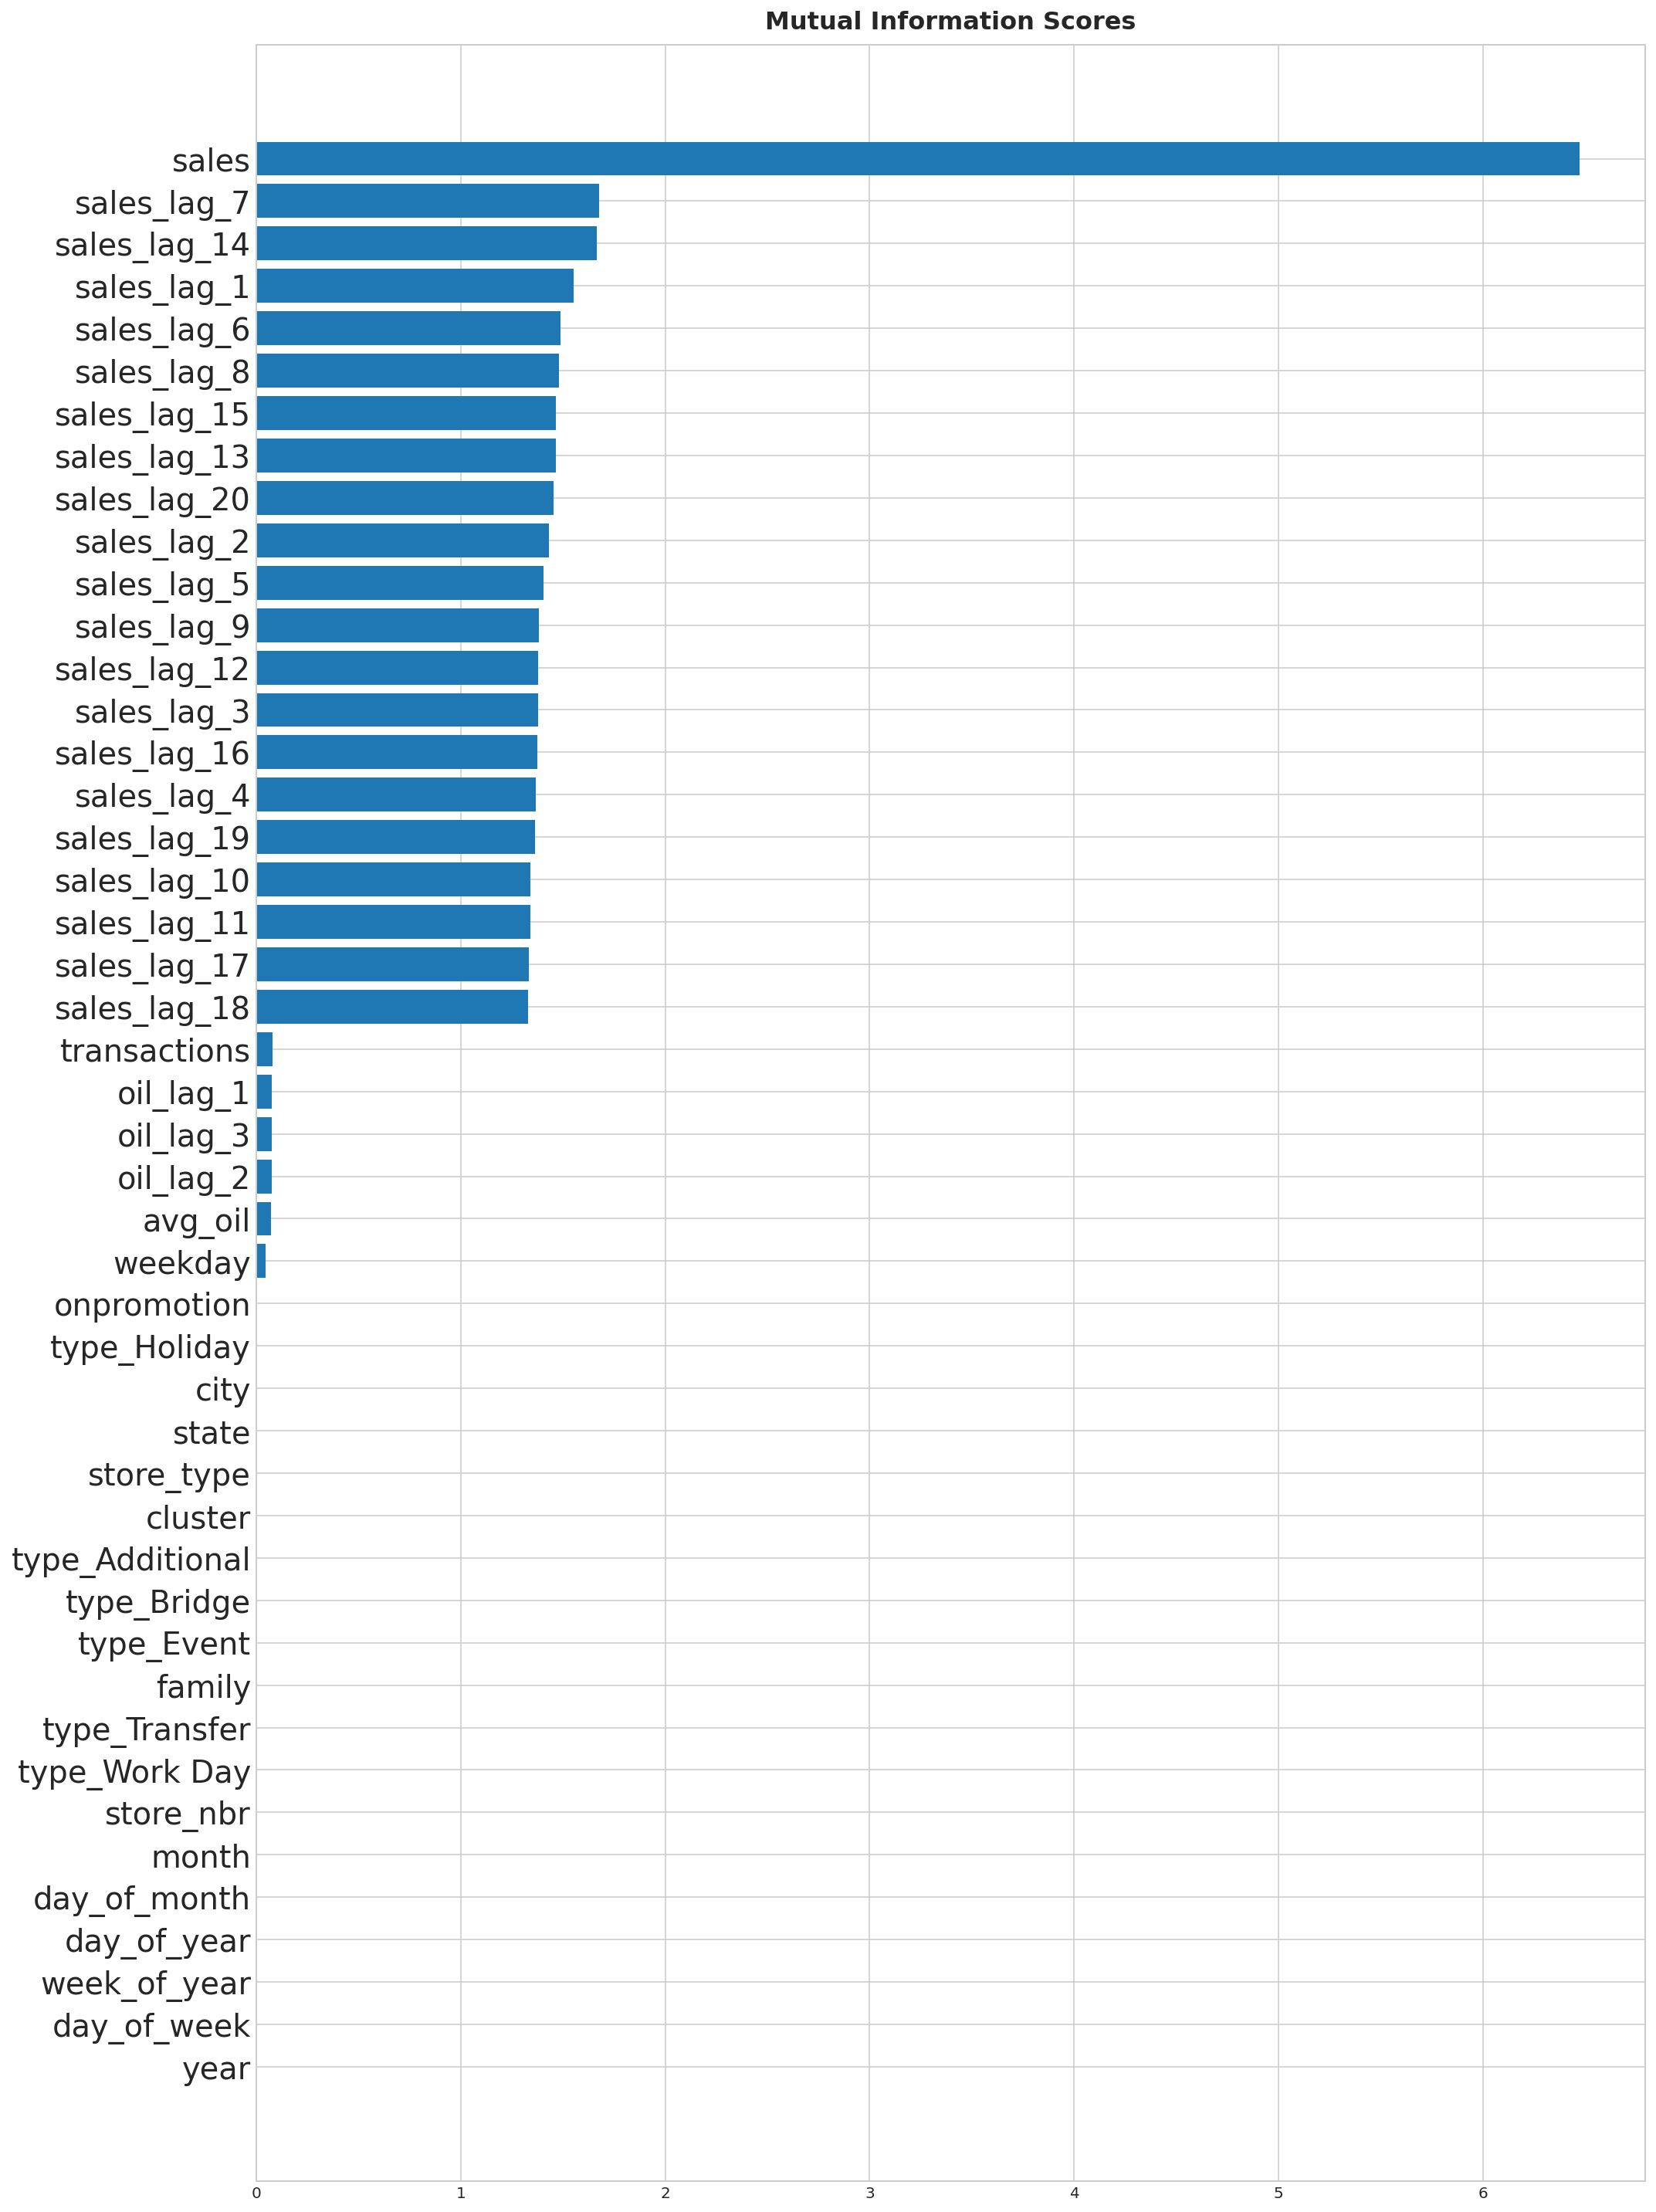

In [42]:
plot_scores(mi_scores, "Mutual Information Scores")

In [43]:
y = data[['date', 'sales']].copy()
y.set_index('date', inplace=True)
data.drop('sales', axis=1, inplace=True)

X = data.query("'2014-01-01' <= date <= '2017-08-15'")
X_test = data.query("date >= '2017-08-16'")
y = y.loc['2014-01-01':'2017-08-15']

X.drop('date', axis=1, inplace=True)
X_test.drop('date', axis=1, inplace=True)
y.set_index(X.index, inplace=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape)

(1764180, 45) (1764180, 1)
(588060, 45) (588060, 1)
(28512, 45)


## Modeling

for predicting sales values in days 2017-08-16 to 2017-08-31, at day 17 we dont have value of sales_lag_1, at day 18 we dont have values of sales_lag_1, sales_lag_2, and so on ...
so after predicting day 16's target value, we're gonna to fill day 17's sale_lag_1, day 18's sale_lag_2 and ... with that value.
and also do the same after predicting day 17's target value and the other days.
this called "recursive predicting" in the term of time series problems.

In [44]:
def recursive_predict(model, df):
    df_temp = df.copy()
    output = np.array([])
    day_start, day_end = df_temp['day_of_month'].min(), df_temp['day_of_month'].max()
    for day in range(day_start, day_end+1):
        pred = model.predict(df_temp.query(f"day_of_month == {day}"))
        # print(pred)
        pred[pred < 0] = 0
        output = np.concatenate([output, pred], axis=0)
        for k in range(day+1, day_end+1):
            df_temp.loc[df_temp[df_temp["day_of_month"] == k].index, f"sales_lag_{k-day}"] = pred

    return output

we will use ridge regression as the base model, and then try to catch a better model

In [45]:
preproccessor = ColumnTransformer(
    transformers=[
        ("oh_encode", OneHotEncoder(sparse=False), ['store_nbr', 'family', 'city', 'state', 'store_type']),
    ]
)
model = Pipeline(steps=[
    ("preproc", preproccessor),
    ("model", LinearRegression())])
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_train[y_pred_train < 0] = 0
y_pred_val = model.predict(X_val)
y_pred_val[y_pred_val < 0] = 0

print("RMSLE train: ", np.sqrt(mean_squared_log_error(y_train, y_pred_train)))
print("RMSLE val: ", np.sqrt(mean_squared_log_error(y_val, y_pred_val)))

RMSLE train:  0.4845032238303668
RMSLE val:  0.4844757039833515


In [46]:
lgb_params = {
    'metric': 'mse',
    'boosting_type' : 'gbdt',
    'num_leaves': 8,
    'learning_rate': 0.2,
    'max_depth': 7,
    'verbose': 0,
    'num_boost_round': 5000,
    'early_stopping_rounds': 200,
    'nthread': -1,
    'force_col_wise': True,
    'random_state': 42
}

train_dataset = lgb.Dataset(data=X_train, label=y_train, feature_name='auto')
val_dataset = lgb.Dataset(data=X_val, label=y_val, reference=train_dataset, feature_name='auto')

In [47]:
model = lgb.train(
    params=lgb_params, 
    train_set=train_dataset,
    valid_sets=[train_dataset, val_dataset],
    verbose_eval=100,
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.180429	valid_1's l2: 0.18283
[200]	training's l2: 0.165057	valid_1's l2: 0.167971
[300]	training's l2: 0.157288	valid_1's l2: 0.16045
[400]	training's l2: 0.152896	valid_1's l2: 0.156428
[500]	training's l2: 0.149822	valid_1's l2: 0.153539
[600]	training's l2: 0.147148	valid_1's l2: 0.151229
[700]	training's l2: 0.145141	valid_1's l2: 0.149572
[800]	training's l2: 0.143353	valid_1's l2: 0.148091
[900]	training's l2: 0.141808	valid_1's l2: 0.146811
[1000]	training's l2: 0.140611	valid_1's l2: 0.145855
[1100]	training's l2: 0.139445	valid_1's l2: 0.144992
[1200]	training's l2: 0.13836	valid_1's l2: 0.144115
[1300]	training's l2: 0.137373	valid_1's l2: 0.143377
[1400]	training's l2: 0.136519	valid_1's l2: 0.142803
[1500]	training's l2: 0.135688	val

In [48]:
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_train[y_pred_train < 0] = 0

print("RMSLE train: ", np.sqrt(mean_squared_log_error(y_train, y_pred_train)))

RMSLE train:  0.1575016128101569


In [49]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_val[y_pred_val < 0] = 0

print("RMSLE val: ", np.sqrt(mean_squared_log_error(y_val, y_pred_val)))

RMSLE val:  0.16366270569379002


In [50]:
y_pred_test = recursive_predict(model, X_test)
y_pred_test

array([1.66722763, 0.03635744, 1.90609392, ..., 7.20990465, 5.21227891,
       2.60730817])

In [51]:
final_submission = pd.DataFrame({'id': X_test.index, 'sales': np.expm1(y_pred_test)})
final_submission.to_csv('submission.csv', index=False)